In [99]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz

#### Using train-test splits from HBM file

In [78]:
X_train = pd.read_excel('xtrain.xlsx').drop(columns = ['Unnamed: 0'])
X_test = pd.read_excel('xtest.xlsx').drop(columns = ['Unnamed: 0'])
Y_train = pd.read_excel('ytrain.xlsx').drop(columns = ['Unnamed: 0'])
Y_test = pd.read_excel('ytest.xlsx').drop(columns = ['Unnamed: 0'])
maxes_train = pd.read_excel('maxes.xlsx')
mins_train = pd.read_excel('mins.xlsx')

#### Model Creation

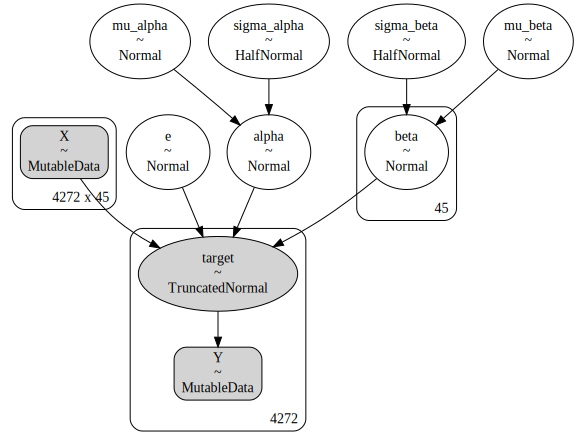

In [28]:
model = pm.Model()

with model:
       
    X = pm.MutableData("X", X_train)
    Y = pm.MutableData("Y", Y_train['LOS'])
    
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=3)
    sigma_alpha = pm.HalfNormal('sigma_alpha',5)
    mu_beta = pm.Normal('mu_beta', mu=0.5, sigma=5)
    sigma_beta = pm.HalfNormal('sigma_beta', 7)
    error = pm.Normal('e' , mu = 0, sigma = 3)
    
    alpha = pm.Normal('alpha', mu_alpha,sigma_alpha) 
    betas = pm.Normal('beta', mu_beta, sigma_beta, shape = X_train.shape[1])
    
    y = alpha + pm.math.dot(X, betas) + error    

    target = pm.TruncatedNormal('target', mu = y,lower=0,upper=1, observed = Y)


pm.model_to_graphviz(model)


#### Sampling

In [39]:
with model:
    
    step = pm.NUTS(target_accept = 0.99)
    trace = pm.sample(3000,init='ADVI+adapt_diag',return_inferencedata=True, tune = 1000, step = step, chains = 2)

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, mu_beta, sigma_beta, e, alpha, beta]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 1457 seconds.


#### Results

C:\ProgramData\Anaconda3\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (51) in plot_posterior, generating only 40 plots
  warnings.warn(


               mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_alpha     26.780  25.307 -14.303   62.119     14.142   11.086       4.0   
mu_beta       0.073   0.014   0.042    0.097      0.004    0.003      11.0   
e           -25.539  13.275 -48.684  -10.280      8.071    6.469       3.0   
beta[0]       0.086   0.036   0.021    0.153      0.007    0.005      27.0   
beta[1]       0.125   0.040   0.067    0.202      0.015    0.011       8.0   
beta[2]       0.146   0.048   0.059    0.235      0.008    0.006      44.0   
beta[3]       0.084   0.036   0.011    0.153      0.013    0.010       7.0   
beta[4]       0.118   0.057   0.003    0.219      0.007    0.005      67.0   
beta[5]       0.074   0.054  -0.006    0.194      0.021    0.015       8.0   
beta[6]       0.119   0.043   0.029    0.192      0.013    0.009       9.0   
beta[7]       0.034   0.025  -0.019    0.083      0.002    0.002      90.0   
beta[8]       0.083   0.048  -0.013    0.162      0.010    0.007

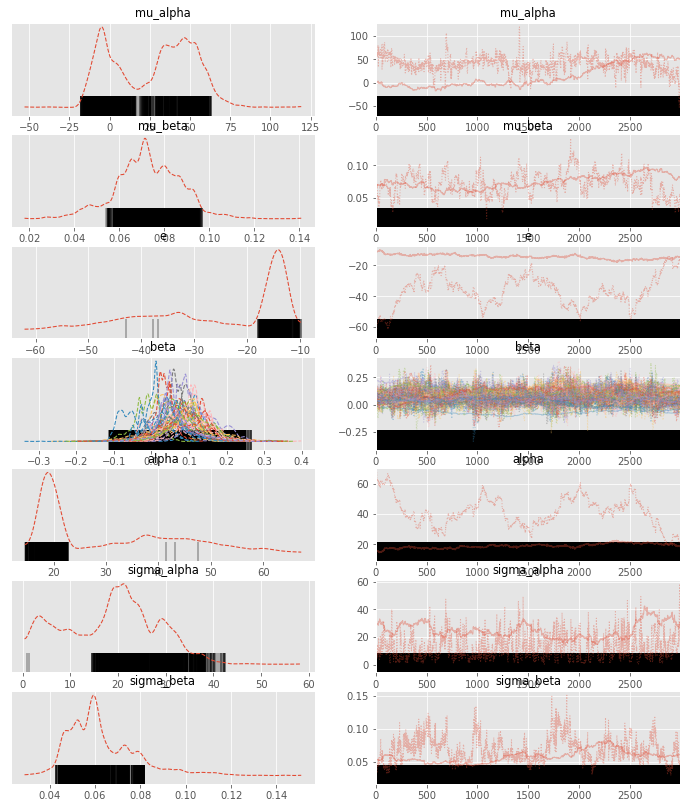

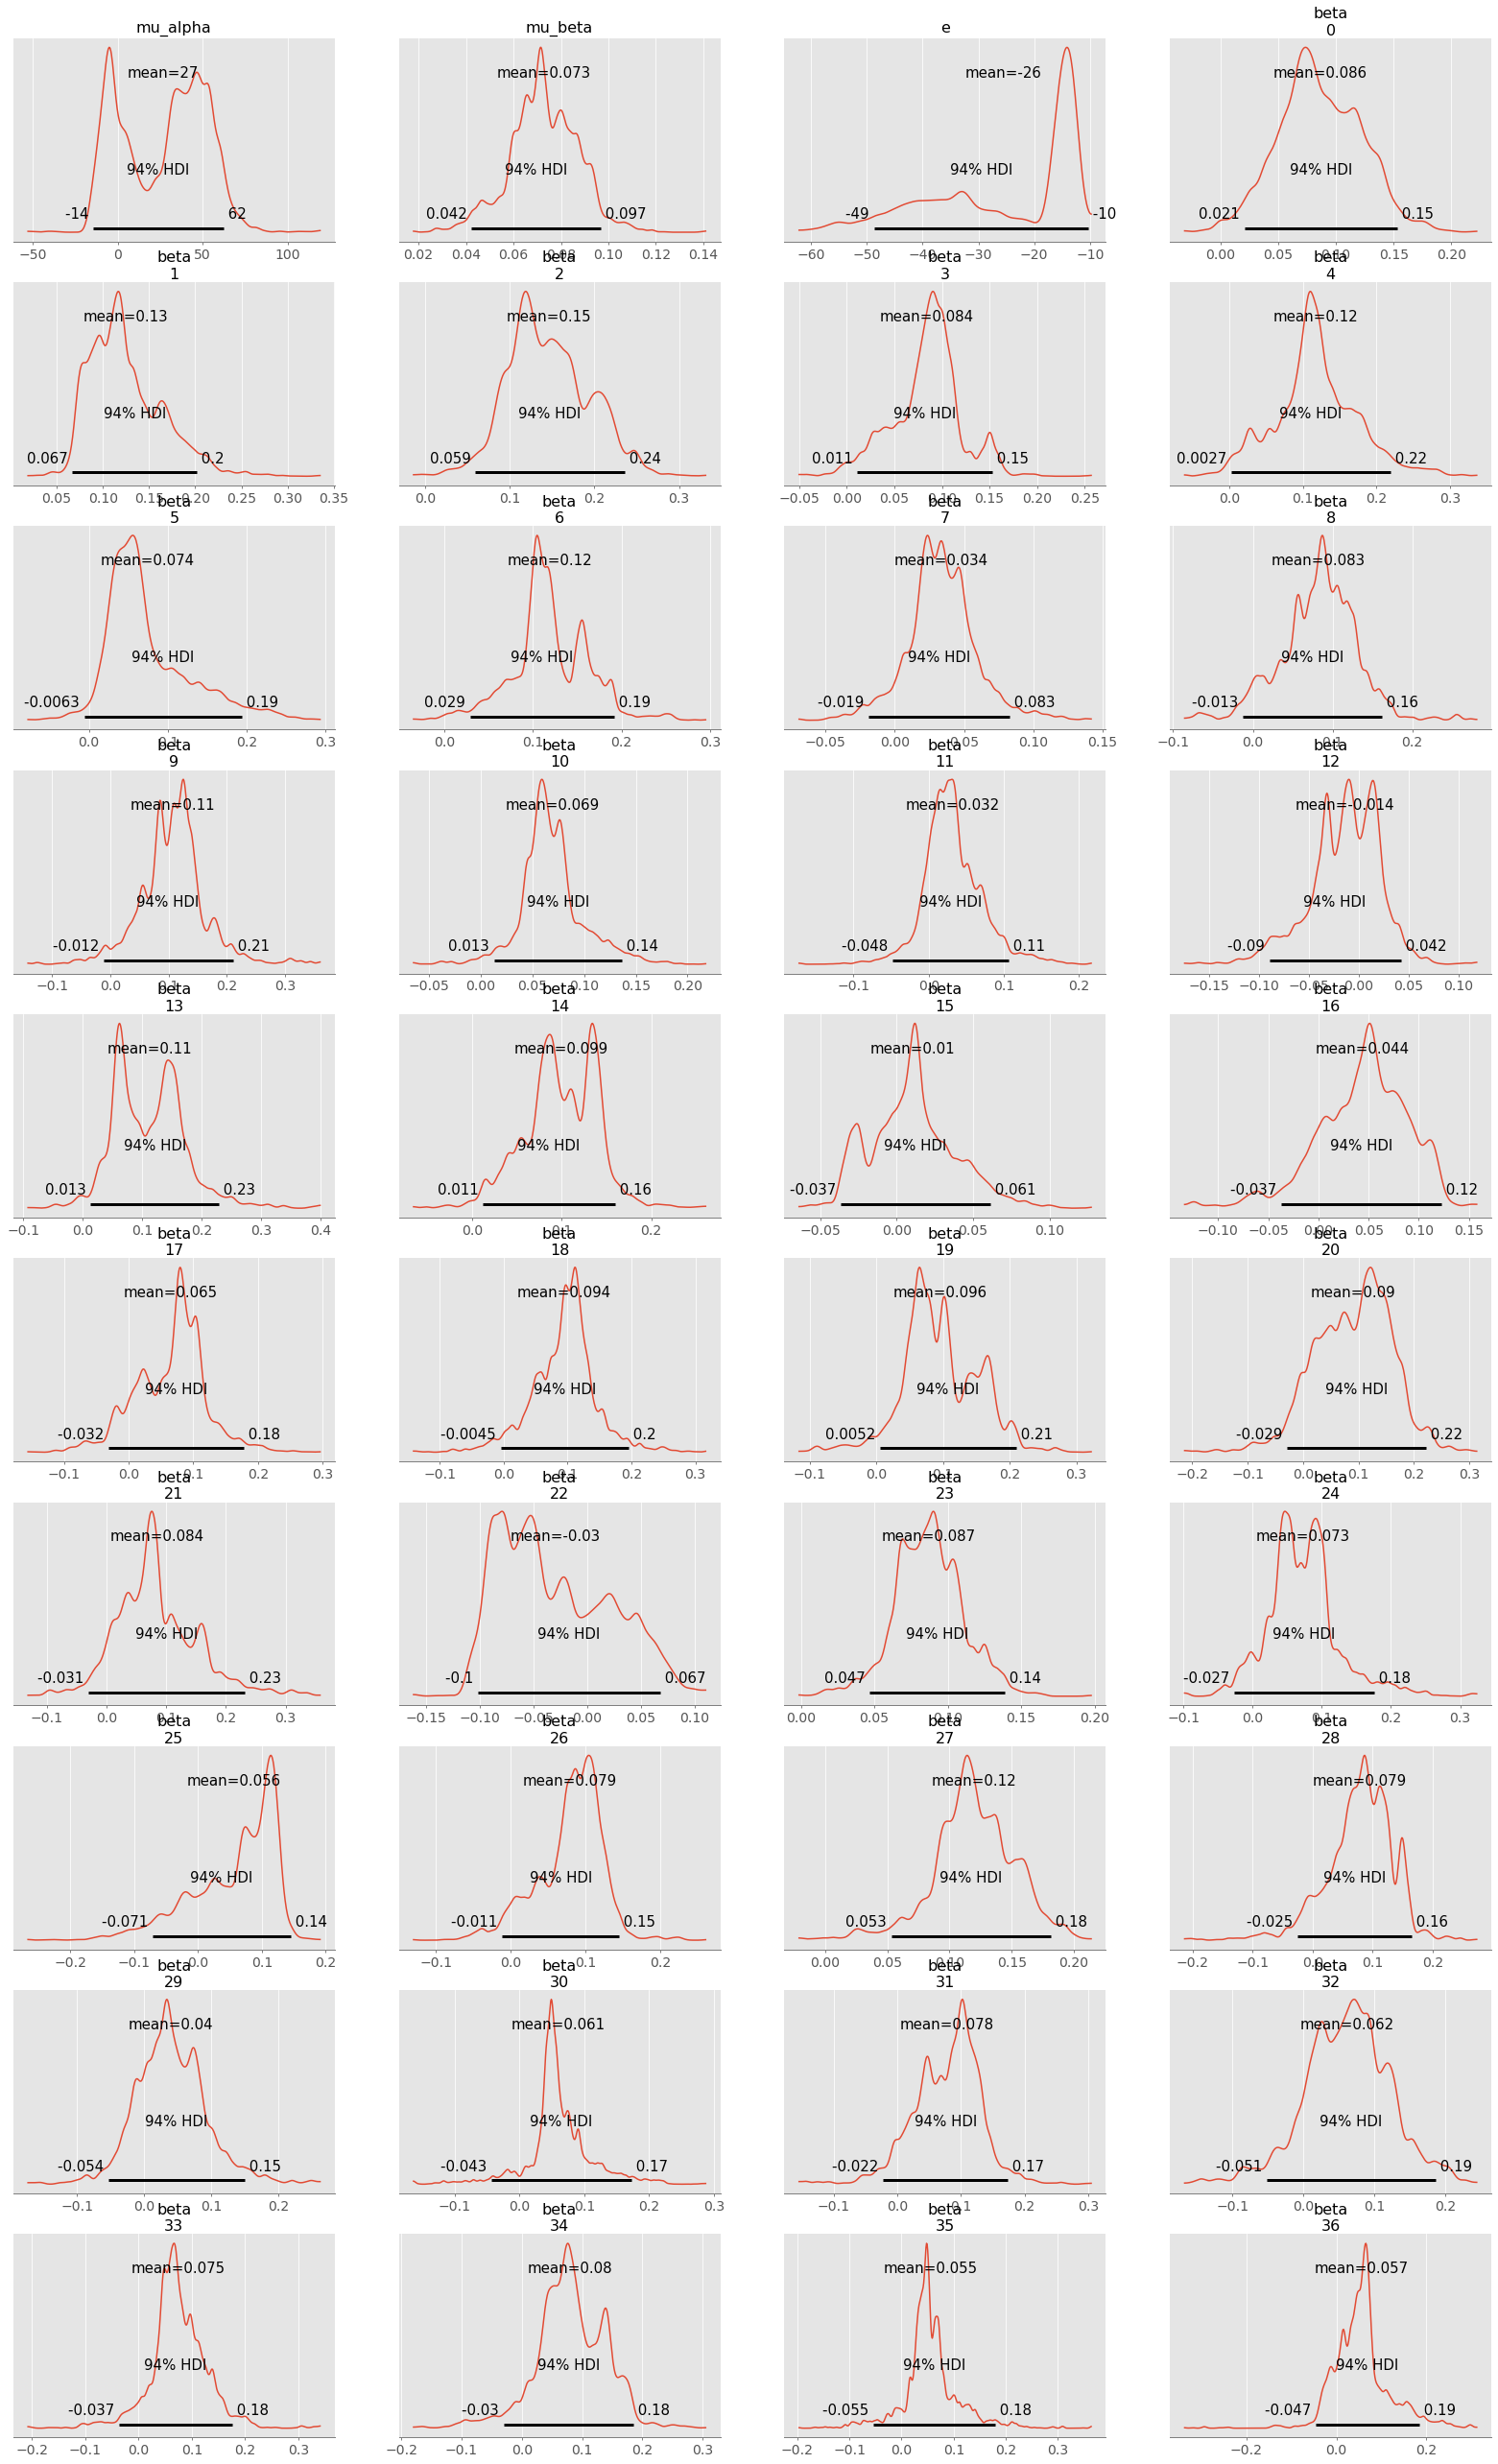

In [54]:
with model:
    arviz.plot_trace(trace, combined = True)
    arviz.plot_posterior(trace)
    print(pm.summary(trace))

#### Predictions

In [93]:
# Getting predictions
with model:
    pm.set_data({"X": X_test, "Y": Y_test['LOS']})
    trace.extend(pm.sample_posterior_predictive(trace, var_names = ['target','beta'],random_seed = 70, extend_inferencedata = True))

Sampling: [beta, target]


In [89]:
# Scaling parameters from training set
max_train_los = int(maxes_train[maxes_train['col'] == 'LOS']['Max'].values.tolist()[0]) 
min_train_los = int(mins_train[mins_train['col'] == 'LOS']['Min'].values.tolist()[0])

In [94]:
# Unscaling of predictions
predicted = trace.posterior_predictive["target"].mean(dim=["chain", "draw"])
predicted_unscaled = predicted * (max_train_los - min_train_los) + min_train_los
Y_test_unscaled = Y_test * (max_train_los - min_train_los) + min_train_los

#### Evaluation

In [75]:
# Metrics
from sklearn import metrics
meanAbErr = metrics.mean_absolute_error(Y_test_unscaled, predicted_unscaled)
meanSqErr = metrics.mean_squared_error(Y_test_unscaled, predicted_unscaled)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(Y_test_unscaled, predicted_unscaled))
mean = predicted_unscaled.mean()
std = predicted_unscaled.std()
min = predicted_unscaled.min()
max = predicted_unscaled.max()
cv = std/mean
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)
print('Mean:', mean )
print('STD: ', std)
print('Min:', min)
print('Max:', max)
print('CV:', cv)


Mean Absolute Error: 2.052447947234799
Mean Square Error: 11.29687932567157
Root Mean Square Error: 3.3610830584309532
Mean: 8.317916445595882
STD:  1.4148293386042852
Min: 5.0
Max: 15.9661563
CV: 0.17009419941377266


In [74]:
# Some more metrics
rss = pow((predicted_unscaled - Y_test_unscaled['LOS']),2).sum()
tss = pow((Y_test_unscaled['LOS'] - Y_test_unscaled['LOS'].mean()), 2).sum()
rsq = 1-(rss/tss)
print('Rsq: ', rsq*100)
adj_r2 = 1-(1-rsq)* ((Y_test_unscaled.shape[0]-1)/(Y_test_unscaled.shape[0]-X_test.shape[1]-1))
print('Adj Rsq: ', adj_r2*100)
print(rss)
print(tss)

Rsq:  15.641706389484156
Adj Rsq:  11.930931010722468
12076.363999142908
14315.562207670719
